In [1]:
import os
import sys

sys.path.append('../')

In [2]:
import torch
import numpy as np
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.metrics import accuracy_score

In [3]:
from pydil.ot_utils.pot_utils import gmm_emd
from pydil.ot_utils.pot_utils import map_gaussians
from pydil.ot_utils.barycenters import bures_wasserstein_barycenter
from pydil.toy_datasets.domain_adaptation.msda import msda_toy_example

2023-07-16 13:04:08.746060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 13:04:08.855500: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 13:04:08.871790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-16 13:04:09.150748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [4]:
def estimate_proportions(Y):
    y = Y.argmax(dim=1)
    u, c = torch.unique(y, return_counts=True)
    
    return c / c.sum()

In [5]:
def plot_cov_ellipse(pos, cov, nstd=2, ax=None, c='k', alpha=1.0):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos,
                    width=width,
                    height=height,
                    angle=theta,
                    facecolor='none',
                    edgecolor=c,
                    linewidth=2,
                    zorder=25,
                    alpha=alpha)

    ax.add_artist(ellip)
    return ellip

In [6]:
n_dim = 2
n_classes = 2
n_components = 3
n_datasets = 4
n_samples = 500
angle_min = 5
angle_max = 45

In [7]:
Xs, Ys, Xt, Yt = msda_toy_example(n_datasets,
                     n_samples=n_samples,
                     angle_min=angle_min,
                     angle_max=angle_max,
                     separation=6)

In [8]:
features = torch.cat(Xs + [Xt], dim=0)
labels = torch.cat(Ys + [Yt], dim=0)

In [9]:
xmin, xmax = features[:, 0].min(), features[:, 0].max()
ymin, ymax = features[:, 1].min(), features[:, 1].max()
print(xmin, xmax, ymin, ymax)

tensor(-3.5925) tensor(9.5859) tensor(-6.4618) tensor(7.6250)


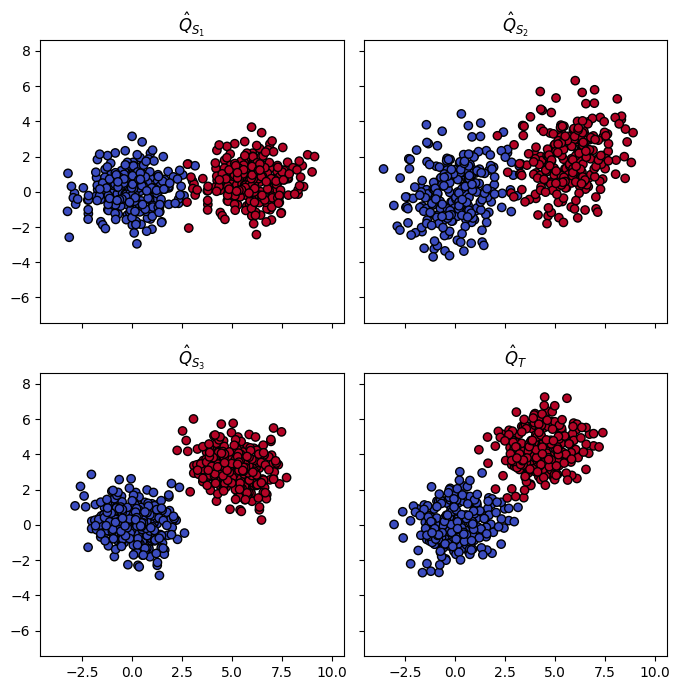

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(Xs, Ys, axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
# ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c='gray', edgecolor='k')
ax.scatter(x=Xt[::2, 0], y=Xt[::2, 1], c=Yt[::2, 1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

In [11]:
MQ, SQ, BQ = [], [], []
for Xsk, Ysk in zip(Xs, Ys):
    MQ.append(torch.stack([
        Xsk[Ysk.argmax(dim=1) == c].mean(dim=0) for c in range(n_classes)
    ]))
    
    SQ.append(torch.stack([
        Xsk[Ysk.argmax(dim=1) == c].std(dim=0) for c in range(n_classes)
    ]))
    
    BQ.append(estimate_proportions(Ysk))
MQ = torch.stack(MQ)
SQ = torch.stack(SQ)
BQ = torch.stack(BQ)

In [12]:
gmm_t = GaussianMixture(n_components=2, covariance_type='diag')
gmm_t.fit(Xt)

GaussianMixture(covariance_type='diag', n_components=2)

In [13]:
Mt = torch.from_numpy(gmm_t.means_.reshape(2, 2)).float()
St = torch.from_numpy(np.sqrt(gmm_t.covariances_).reshape(2, 2)).float()
Bt = torch.from_numpy(gmm_t.weights_).float()

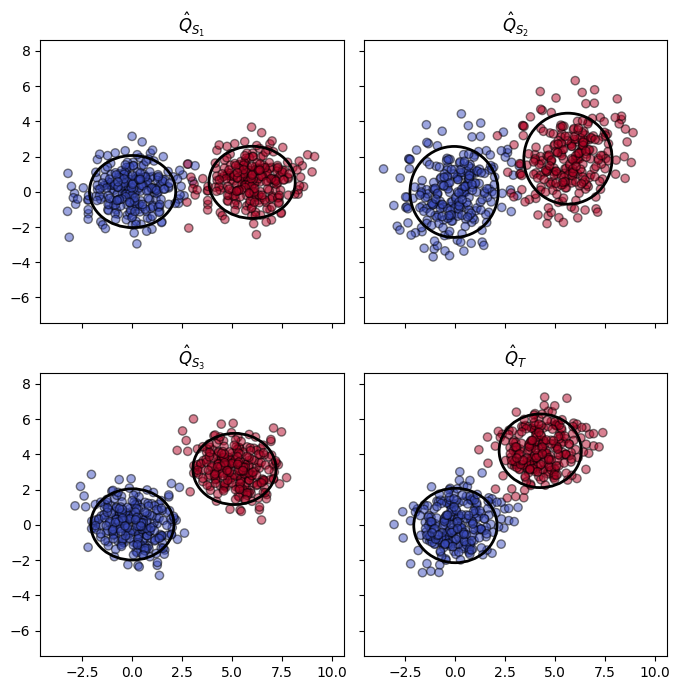

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for l in range(n_datasets - 1):
    for c in range(n_classes):
        plot_cov_ellipse(pos=MQ[l, c],
                         cov=np.diag(SQ[l, c]),
                         ax=axes.flatten()[l])

        axes.flatten()[l].set_xlim([xmin - 1, xmax + 1])
        axes.flatten()[l].set_ylim([ymin - 1, ymax + 1])

for c in range(n_classes):
    plot_cov_ellipse(pos=Mt[c],
                     cov=np.diag(St[c]),
                     ax=axes.flatten()[-1])

    axes.flatten()[-1].set_xlim([xmin - 1, xmax + 1])
    axes.flatten()[-1].set_ylim([ymin - 1, ymax + 1])

        
for i, (Xi, Yi, ax) in enumerate(zip(Xs, Ys, axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k', alpha=0.5)
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
ax.scatter(x=Xt[::2, 0], y=Xt[::2, 1], c=Yt[::2, 1], cmap='coolwarm', edgecolor='k', alpha=0.5)
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

In [15]:
MQ.shape

torch.Size([3, 2, 2])

In [24]:
MB = []
SB = []
for c in range(2):
    mBc, sBc = bures_wasserstein_barycenter(MQ[:, c, :], SQ[:, c, :], cov_type='diag')
    MB.append(mBc)
    SB.append(sBc.diag())
MB = torch.stack(MB)
SB = torch.stack(SB)

In [46]:
MQ.shape

torch.Size([3, 2, 2])

In [47]:
A_sb, b_sb = {}, {}

for k in range(len(MQ)):
    for c in range(n_classes):
        Akc, bkc = map_gaussians(MQ[k, c], SQ[k, c], MB[c, :], SB[c, :], cov_type='diag')
        A_sb[k, c] = Akc
        b_sb[k, c] = bkc

In [54]:
XB = []
YB = []

for k in range(len(MQ)):
    for c in range(n_classes):
        ind = torch.where(Ys[k].argmax(dim=1) == c)[0]
        XB.append(Xs[k][ind] @ A_sb[k, c] + b_sb[k, c])
        YB.append(Ys[k][ind])
XB = torch.cat(XB, dim=0)
YB = torch.cat(YB, dim=0)

(-7.461839199066162, 8.624966621398926)

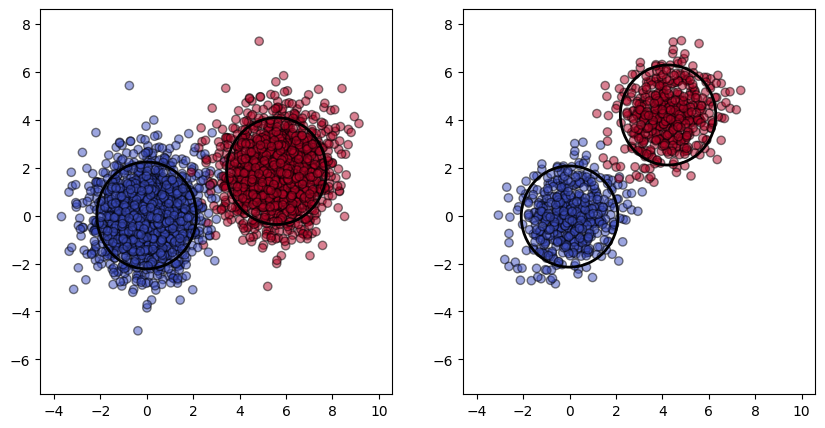

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(XB[:, 0], XB[:, 1], c=YB[:, 1], cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)

for c in range(n_classes):
    plot_cov_ellipse(pos=MB[c],
                     cov=np.diag(SB[c]),
                     ax=ax)
ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

ax = axes[1]
ax.scatter(Xt[:, 0], Xt[:, 1], c=Yt[:, 1], cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)

for c in range(n_classes):
    plot_cov_ellipse(pos=Mt[c],
                     cov=np.diag(St[c]),
                     ax=ax)
ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

In [61]:
ot_plan = gmm_emd(MB, SB, Mt, St, cov_type='diag')

<AxesSubplot: >

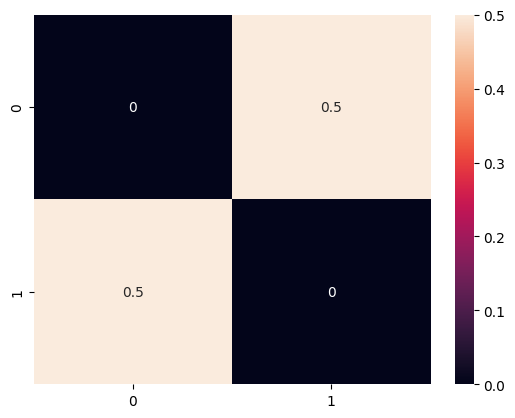

In [74]:
sns.heatmap(ot_plan, annot=True)

(-7.461839199066162, 8.624966621398926)

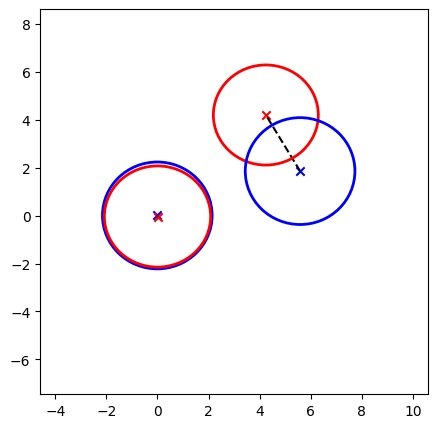

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(MB[:, 0], MB[:, 1], c='b', marker='x')
ax.scatter(Mt[:, 0], Mt[:, 1], c='r', marker='x')

ind_B, ind_t = np.where(ot_plan > 0.0)

for iB, it in zip(ind_B, ind_t):
    ax.plot([MB[iB, 0], Mt[it, 0]], [MB[iB, 1], Mt[it, 1]], 'k--')

for c in range(n_classes):
    plot_cov_ellipse(pos=MB[c],
                     cov=np.diag(SB[c]),
                     ax=ax,
                     c='b')
    
    plot_cov_ellipse(pos=Mt[c],
                     cov=np.diag(St[c]),
                     ax=ax,
                     c='r')    

ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

In [78]:
A_bt, b_bt = [], []

for c in range(n_classes):
    target_component = ot_plan[c, :].argmax()
    Ac, bc = map_gaussians(MB[c, :], SB[c, :], Mt[target_component, :], St[target_component, :], cov_type='diag')
    A_bt.append(Ac)
    b_bt.append(bc)

In [89]:
TXB = []
TYB = []

for c in range(n_classes):
    ind = torch.where(YB.argmax(dim=1) == c)[0]
    TXB.append(XB[ind] @ A_bt[c] + b_bt[c])
    TYB.append(YB[ind])
TXB = torch.cat(TXB, dim=0)
TYB = torch.cat(TYB, dim=0)

(-7.461839199066162, 8.624966621398926)

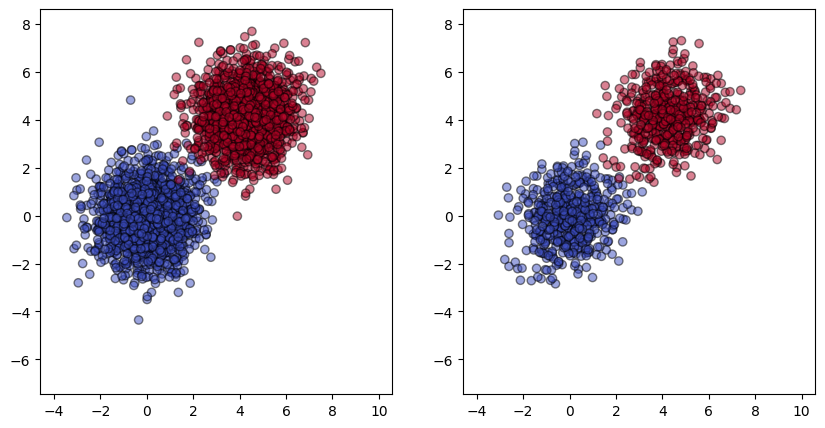

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(TXB[:, 0], TXB[:, 1], c=TYB[:, 1], cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)

ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

ax = axes[1]
ax.scatter(Xt[:, 0], Xt[:, 1], c=Yt[:, 1], cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)

ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])